# Visualize Model Predictions

In [56]:
import json
import sys
import os
from pathlib import Path
import h5py

import numpy as np
import matplotlib.pyplot as plt
import torch

# Import model architecture.
CWD = os.path.join(Path().resolve())
sys.path.append(os.path.abspath(os.path.join(CWD, '..', 'training')))
from models import build_model

In [57]:
# Specify job_id and hyperparamter config id.
config_id = "default"
job_id = 99

# Path to model weights and config file.
job_dir = os.path.abspath(os.path.join(
    CWD, "../trained_models/{0:}/{1:05g}".format(config_id, job_id)
))

# Load config file.
with open(os.path.join(job_dir, 'config.json')) as f:
    CONFIG = json.load(f)

# Load model.
model, _ = build_model(CONFIG)
model.load_state_dict(torch.load(os.path.join(job_dir, "best_weights.pt")))
model.eval();

# Specify data file.
data_dir = os.path.abspath(os.path.join(CWD, "../data"))
data_file = h5py.File(os.path.join(data_dir, "train_set.h5"))

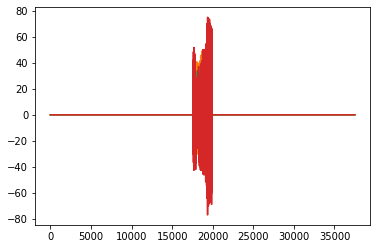

In [58]:
# Plot example vocalization
plt.plot(data_file["vocalizations"][np.random.randint(100)].T)

In [59]:
def compute_model_prediction(idx):
    audio_inputs = torch.from_numpy(data_file["vocalizations"][idx][None, :, :])
    with torch.no_grad():
        return model(audio_inputs)[0].numpy()

def plot_model_prediction(idx):
    targ = data_file["locations"][idx]
    x, y = targ[:, :, 0], targ[:, :, 1]
    pred = compute_model_prediction(idx)
    xhat, yhat = pred[:, :, 0], pred[:, :, 1]
    for c, color in enumerate(("r", "g", "b")):
        plt.scatter(x[:, c], y[:, c], edgecolors=color, facecolors='none', s=100)
        plt.scatter(xhat[:, c], yhat[:, c], color=color, marker="+")
        
    plt.xlim([-.3, .3])
    plt.ylim([-.3, .3])
    plt.title(idx)

In [60]:
from scipy.spatial.distance import pdist
meanlocs = np.array(data_file["locations"]).mean(axis=1)
maxdists = []
for i, M in enumerate(meanlocs):
    maxdists.append(pdist(M).max())
sorted_idx = np.argsort(maxdists)[::-1]

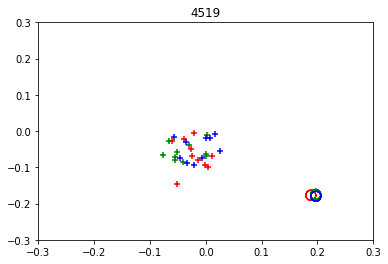

In [68]:
plot_model_prediction(np.random.randint(10000))

In [24]:
audio_input = torch.from_numpy(data_file["vocalizations"][10][None, :, :])
with torch.no_grad():
    h = (torch.tanh(model.f_convs[0](audio_input)) * torch.sigmoid(model.g_convs[0](audio_input)))[0]
# with torch.no_grad():
#     h = torch.relu(model.f_convs[0](audio_input))[0]

(array([1.900e+01, 4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 4.000e+00,
        1.744e+03, 6.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 1.000e+00,
        5.400e+01]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
         0.02040816,  

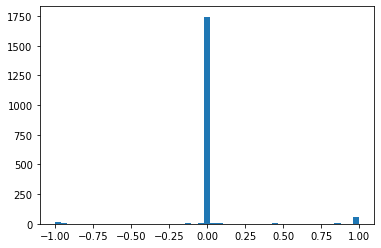

In [25]:
plt.hist(h[0][::10].numpy(), np.linspace(-1, 1, 50))

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.0000000e+00, -8.0000395e-01, -6.0000795e-01, -4.0001190e-01,
        -2.0001587e-01, -1.9848347e-05,  1.9997618e-01,  3.9997220e-01,
         5.9996825e-01,  7.9996425e-01,  9.9996030e-01], dtype=float32),
 <a list of 1875 BarContainer objects>)

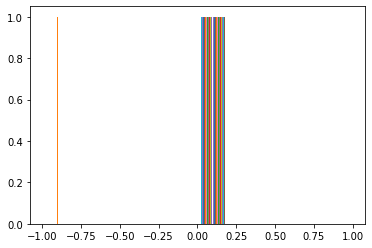

In [9]:
plt.hist(h[0][::10])

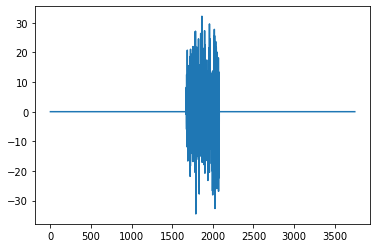

In [10]:
plt.plot(audio_input[0][0][::10])